import copy
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import networkx
from ItalySetup import ItalySetup
from covidOCP import COVIDVaccinationOCP, COVIDParametersOCP
from main import pick_scenario, build_scenario
import seaborn as sns
import datetime
import pickle

nx = 9
states_names = ['S', 'E', 'P', 'I', 'A', 'Q', 'H', 'R', 'V']
outdir = 'model_output/'
when = 'future'
file_prefix = f'week'
#file_prefix = f'2021-01-14_nanoechopc'
#outdir = '2021-01-14_nanoechopc'

baseline = None

n_int_steps = 6
nnodes = 107  # nodes
ndays = 30

setup = ItalySetup(nnodes, ndays, when)
M = setup.nnodes
N = len(setup.model_days) - 1

with open(f'italy-data/parameters_{nnodes}_{when}.pkl', 'rb') as inp:
    p = pickle.load(inp)# Analysis of time series and integration

In [1]:
import copy
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import networkx
from ItalySetup import ItalySetup
from covidOCP import COVIDVaccinationOCP, COVIDParametersOCP
from main import pick_scenario, build_scenario
import seaborn as sns
import datetime
import pickle

nx = 9
states_names = ['S', 'E', 'P', 'I', 'A', 'Q', 'H', 'R', 'V']
outdir = 'model_output/'
when = 'future'
file_prefix = f'week'
#file_prefix = f'2021-01-14_nanoechopc'
#outdir = '2021-01-14_nanoechopc'

baseline = None

n_int_steps = 6
nnodes = 107  # nodes
ndays = 90

setup = ItalySetup(nnodes, ndays, when)
M = setup.nnodes
N = len(setup.model_days) - 1

with open(f'italy-data/parameters_{nnodes}_{when}.pkl', 'rb') as inp:
    p = pickle.load(inp)

Loaded Italy Setup with 107 nodes.


In [2]:
filename = 'model_output/scenarios/U-r15-t479700-id16-opi-107_180.csv'
mydata = pd.read_csv(filename, index_col= 'date', parse_dates=True)
maxvaccrate_regional, stockpile_national, stockpile_national_constraint, control_initial = build_scenario(setup, pick_scenario(setup, int(filename.split('-')[-3][2:])))
mydata['valuepop'] = mydata['value'] / setup.pop_node[mydata['placeID']]

In [3]:
baseline = pd.read_csv('model_output/scenarios/U-r1-t125000-id0-novacc-107_180.csv', index_col= 'date', parse_dates=True)

In [4]:
mydata = mydata[mydata.index < str(setup.end_date)]
baseline = baseline[baseline.index < str(setup.end_date)]
idx = mydata[(mydata['comp'] == 'vacc')].pivot(columns = 'place', values='value').index

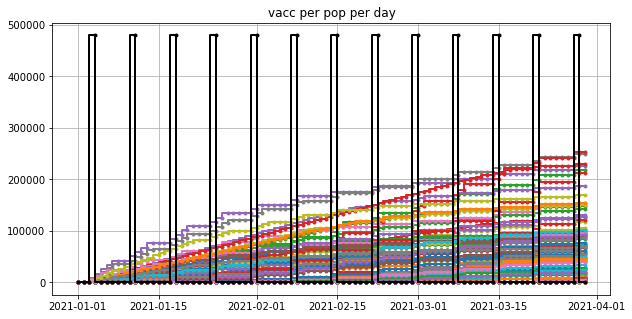

In [5]:
fig, ax = plt.subplots(1,1, figsize = (10,5))
i = 8
st = states_names[i]
st = 'vacc'
value = 'value'

ax.step(idx, mydata[(mydata['comp'] == st)].pivot(columns = 'place', values=value).cumsum()/, lw = 2, ls = '-', marker='.')
#ax.step(idx, stockpile_national, lw = 2, ls = '-', marker='.', c = 'k')

ax.set_title(st + ' per pop per day');
ax.grid()

In [10]:
mydata[(mydata['comp'] == 'vacc') & (mydata['place'] == nd)]['valuepop'].cumsum()

date
2021-01-01    0.000000e+00
2021-01-02    0.000000e+00
2021-01-03    0.000000e+00
2021-01-04    0.000000e+00
2021-01-05    0.000000e+00
                  ...     
2021-03-26    0.000000e+00
2021-03-27    0.000000e+00
2021-03-28    0.000000e+00
2021-03-29    8.283696e-03
2021-03-30    1.568179e-08
Name: valuepop, Length: 89, dtype: float64

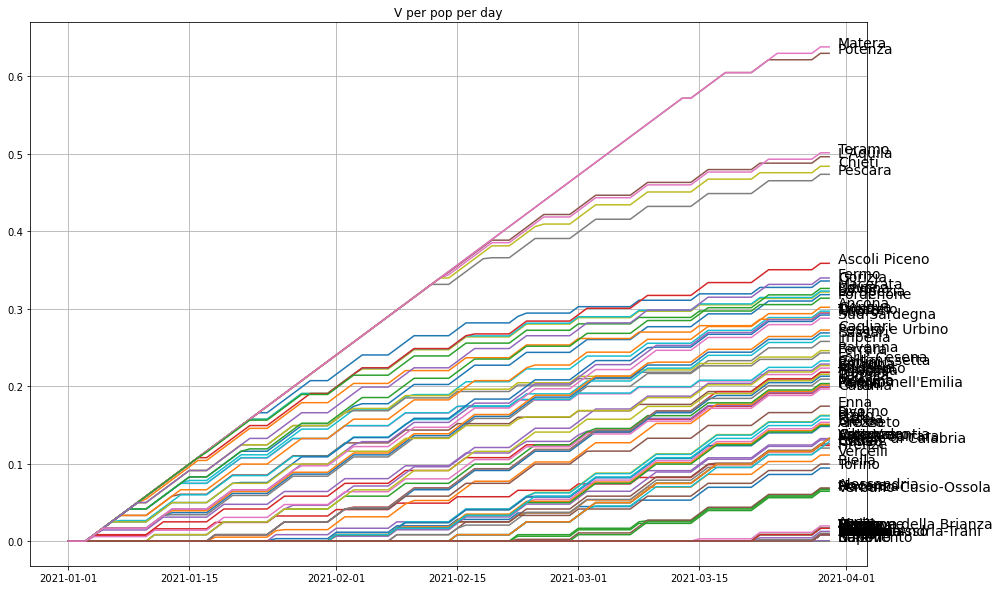

In [17]:
fig, ax = plt.subplots(1,1, figsize = (15,10))
i = 8
st = states_names[i]


for i, nd in enumerate(setup.ind2name):
    ax.plot(mydata[(mydata['comp'] == 'vacc') & (mydata['place'] == nd)]['valuepop'].cumsum())
    plt.text(setup.end_date, 
             max(mydata[(mydata['comp'] == 'vacc') & (mydata['place'] == nd)]['valuepop'].cumsum()),
             nd, fontsize=14)
ax.set_title(st + ' per pop per day');
ax.grid()

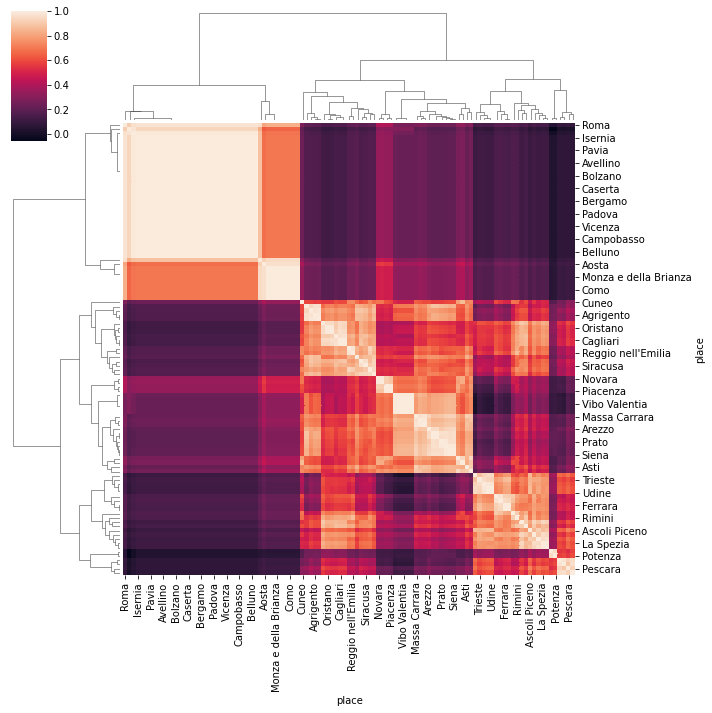

In [5]:
corr_meat = mydata[(mydata['comp'] == 'vacc')].pivot(values = 'value', columns='place').corr(method='pearson')

# Customize the heatmap of the corr_meat correlation matrix
fig = sns.clustermap(corr_meat,
               row_cluster=True,
               col_cluster=True,
               figsize=(10, 10));

plt.setp(fig.ax_heatmap.xaxis.get_majorticklabels(), rotation=90);
plt.setp(fig.ax_heatmap.yaxis.get_majorticklabels(), rotation=0);

In [26]:
corr_meat.shape

(107, 107)

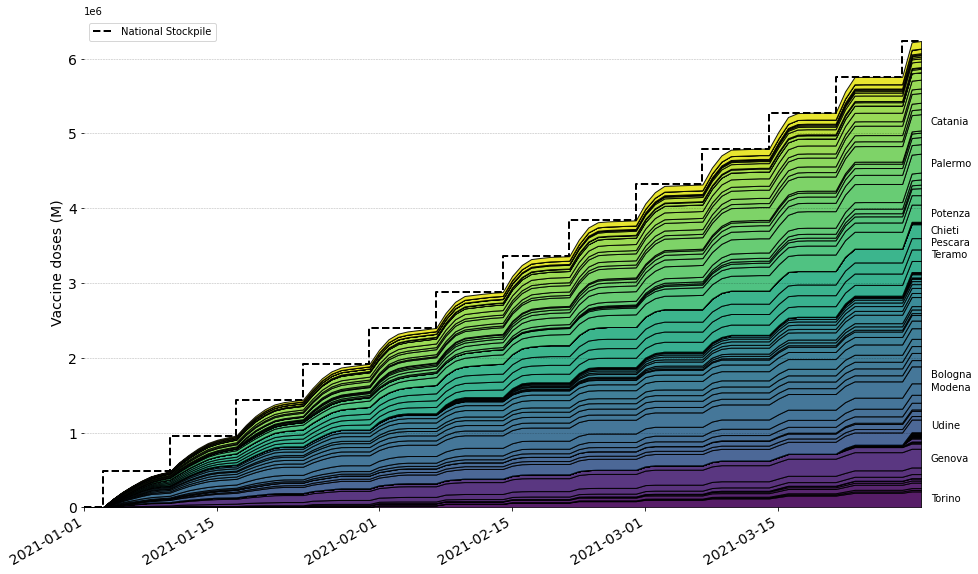

In [8]:
fig, ax = plt.subplots(1,1, figsize = (15,10))
fig.patch.set_facecolor('white')


i = 8
st = states_names[i]
st = 'vacc'
value = 'value'
col = sns.color_palette("viridis", 110)
#col = sns.color_palette("Paired", 110)
ax.grid(True, 'major', 'y', ls='--', lw=.5, c='k', alpha=.3)


#mydata[(mydata['comp'] == st)].pivot(columns = 'place', values=value).cumsum().plot.area(ax = ax, colors=col)# lw = 2, ls = '-', marker='.')
ax.stackplot(idx, [mydata[(mydata['comp'] == st)].pivot(columns = 'place', values=value).cumsum()[pl] for pl in setup.ind2name], 
              edgecolor= 'k', colors = col, lw=1, ls = '-', alpha = .9)

ax.step(idx, stockpile_national.cumsum(), lw = 2, ls = '--',  c = 'k', label = 'National Stockpile') # marker='.',

acc = 0
for i, ndn in enumerate(setup.ind2name):
    this = mydata[(mydata['comp'] == st)].pivot(columns = 'place', values=value).sum()[ndn]
    acc = acc + this
    if this > 1.5e5:
        plt.text(setup.end_date, acc-2*this/3, ndn, fontsize=10)

#ax.set_title('Cumulative vaccination per node', );
ax.set_ylabel('Vaccine doses (M)', fontsize=14);
#ax.grid()
ax.set_xlim(setup.start_date, setup.end_date-datetime.timedelta(1))
ax.legend(loc='upper left')
fig.autofmt_xdate()
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.get_xaxis().tick_bottom()
ax.get_yaxis().tick_left()
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

#ax.grid()
#fig.subplots_adjust(left=.06, right=.75, bottom=.02, top=.94)
fig.savefig('figures/ts_optimal_stackplot.pdf')

In [ ]:
mydata

In [ ]:
fig, axes = plt.subplots(2,2,figsize=(5,5), dpi = 100)


ax.scatter(setup.shp['total_vacc'], 
           setup.shp['population'],
           s=setup.shp.population/max(setup.shp.population)*300, 
           c=setup.shp.population/max(setup.shp.population)*300)
#ax.get_legend().remove();
ax.grid()
ax.set_ylabel('Province population (log)')
ax.set_xlabel('Vaccine doses')
ax.set(yscale="log") 

In [29]:
mydata[(mydata['comp'] == st)].pivot(columns = 'place', values=value).sum()[ndn]

20336.803912700227

No handles with labels found to put in legend.


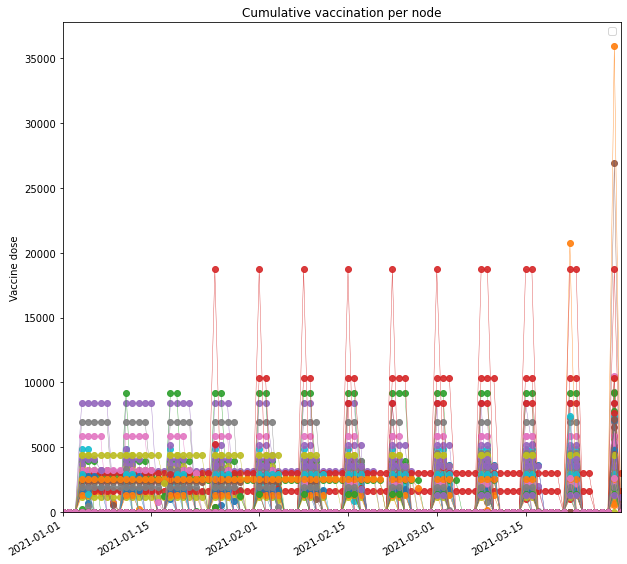

In [53]:
fig, ax = plt.subplots(1,1, figsize = (10,10))
i = 8
st = states_names[i]
st = 'vacc'
value = 'value'
col = sns.color_palette("viridis", 110)
ax.plot(idx, mydata[(mydata['comp'] == st)].pivot(columns = 'place', values=value), lw=.4, ls = '-', alpha = .9,  marker='o')

ax.set_title('Cumulative vaccination per node');
ax.set_ylabel('Vaccine dose');
#ax.grid()
ax.set_xlim(setup.start_date, setup.end_date-datetime.timedelta(1))
ax.set_ylim(0)
ax.legend()
fig.autofmt_xdate()
fig.savefig('figures/ts_optimal.pdf')

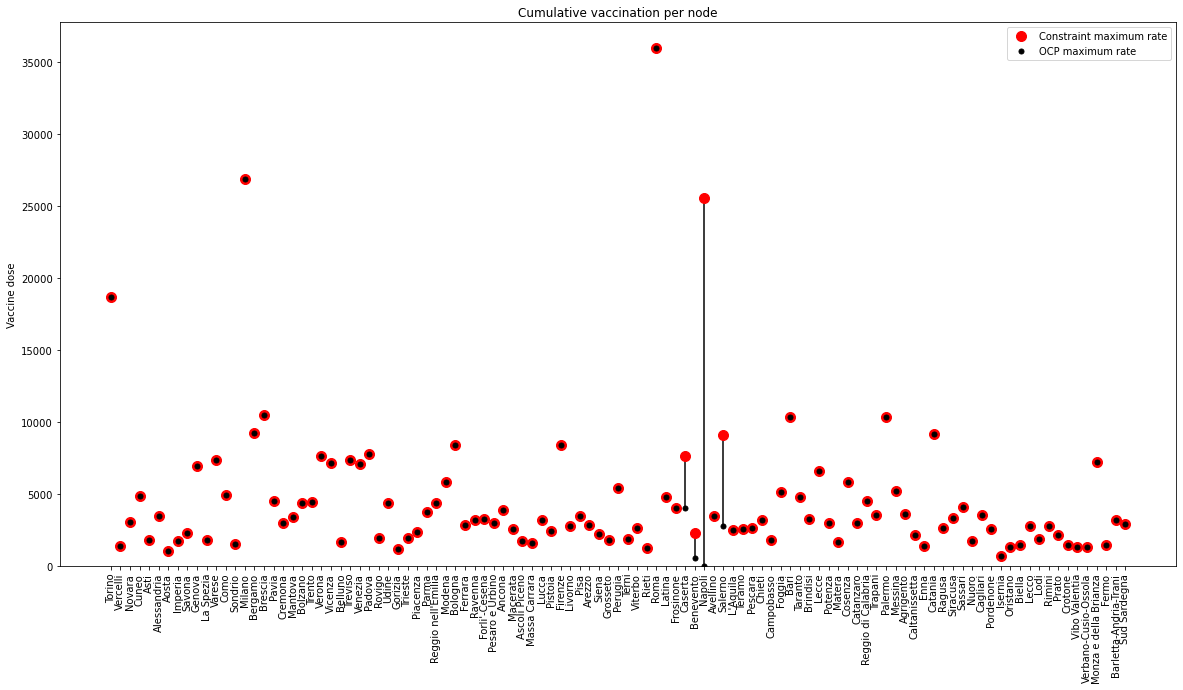

In [54]:
fig, ax = plt.subplots(1,1, figsize = (20,10))
i = 8
st = states_names[i]
st = 'vacc'
value = 'value'
col = sns.color_palette("viridis", 110)

for i in range(len(setup.ind2name)):
    plt.plot([setup.ind2name[i], setup.ind2name[i]],
             [maxvaccrate_regional.max(axis=1)[i], mydata[(mydata['comp'] == st)].pivot(columns = 'place', values=value).max()[setup.ind2name[i]]],
             c='k', ls = '-')
    

ax.plot(setup.ind2name, maxvaccrate_regional.max(axis=1), lw=3, ls = '', alpha = 1,  marker='o', c='r', markersize = 10
       , label = 'Constraint maximum rate')
ax.plot(setup.ind2name, [mydata[(mydata['comp'] == st)].pivot(columns = 'place', values=value).max()[nd] for nd in setup.ind2name], 
        lw=3, ls = '', alpha = 1,  marker='o', c = 'k', markersize = 5, label = 'OCP maximum rate')



ax.set_title('Cumulative vaccination per node');
ax.set_ylabel('Vaccine dose');
#ax.grid()
ax.set_ylim(0)
ax.legend()
plt.xticks(rotation='vertical')
fig.savefig('figures/constraint_dist.pdf')


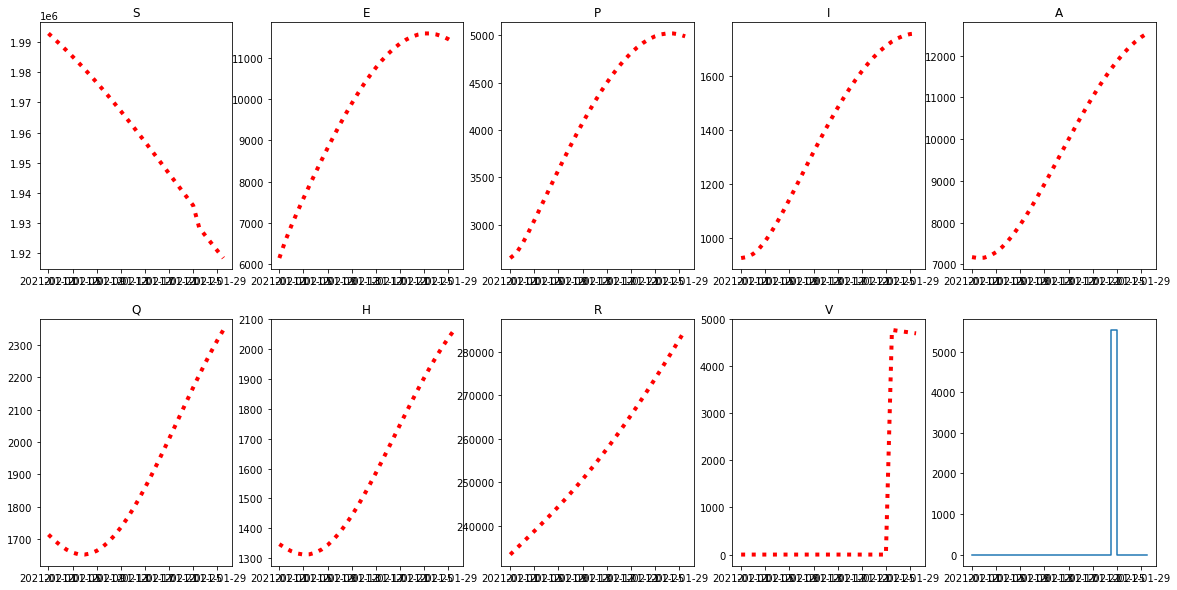

In [14]:
fig, axes = plt.subplots(2,5, figsize = (20,10))
fig.patch.set_facecolor('white')

nd = 0

for i, st in enumerate(states_names):
    axes.flat[i].plot(mydata[(mydata['comp'] == st) & (mydata['placeID'] == nd)]['value'], linestyle=':', lw = 4, color='r')
    if myopt is not None:
        axes.flat[i].plot(myopt[(myopt['comp'] == st) & (myopt['placeID'] == nd)]['value'], linestyle='--', lw = 2, color='g')
    #axes.flat[i].plot(p.matlab_model_days, p.matlab_initial[nd,:,i], linestyle='-', lw = 1, color='k')

    axes.flat[i].set_title(st);

axes.flat[-1].step(mydata[(mydata['comp'] == 'vacc') & (mydata['placeID'] == nd)]['value'].index,
                   mydata[(mydata['comp'] == 'vacc') & (mydata['placeID'] == nd)]['value'], label=r"$\nu(t)$");
if myopt is not None:
    axes.flat[-1].step(myopt[(mydata['comp'] == 'vacc') & (myopt['placeID'] == nd)]['value'].index,
                       myopt[(mydata['comp'] == 'vacc') & (myopt['placeID'] == nd)]['value'], label=r"$\nu(t)$");

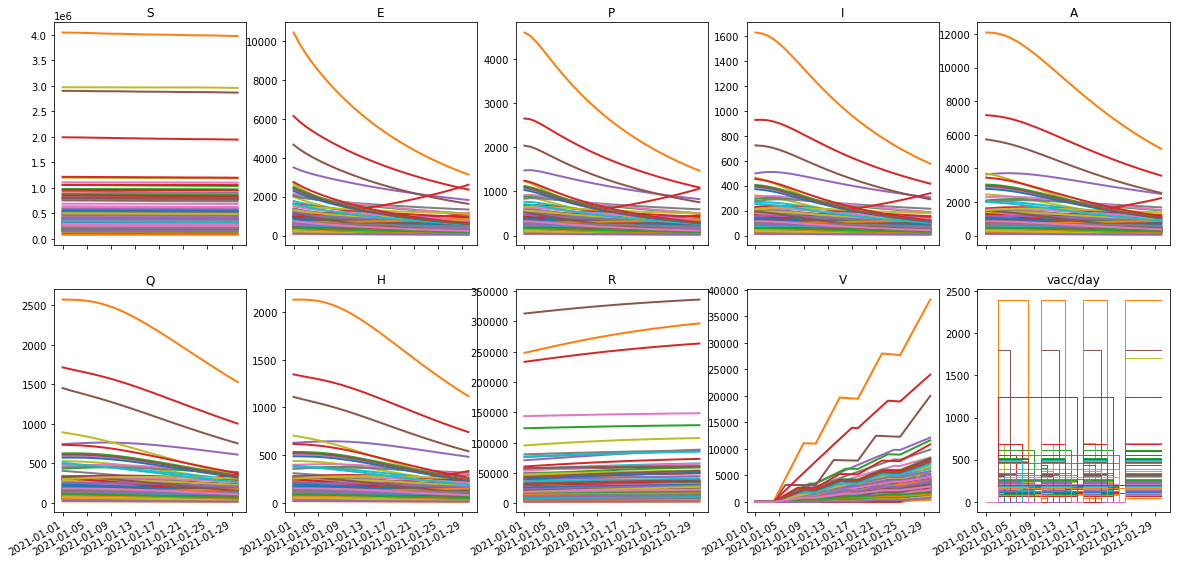

In [5]:
fig, axes = plt.subplots(2,5, figsize = (20,10), sharex=True)

value = 'value'
with sns.color_palette(n_colors=107):   # cycle 10
    for i, st in enumerate(states_names):
        axes.flat[i].plot(mydata[(mydata['comp'] == st)].pivot(columns = 'place', values=value), lw = 2, ls = '-')
        #axes.flat[i].plot(myopt[(myopt['comp'] == st)].pivot(columns = 'place', values='value'), lw = 2, ls = '-')
        #for k in range(M):

        #axes.flat[i].plot(p.matlab_model_days, p.matlab_initial[:,:,i].T, linestyle='-.', lw = .5)
        axes.flat[i].set_title(st);

axes.flat[-1].step(mydata[(mydata['comp'] == 'vacc')].pivot(columns = 'place', values=value).index,
    mydata[(mydata['comp'] == 'vacc')].pivot(columns = 'place', values=value), lw = 1, ls = '-');

#axes.flat[-1].step(myopt[(myopt['comp'] == 'vacc')].pivot(columns = 'place', values='value').index,
    #myopt[(myopt['comp'] == 'vacc')].pivot(columns = 'place', values='value'), lw = 2);
axes.flat[-1].set_title('vacc/day')
fig.autofmt_xdate()

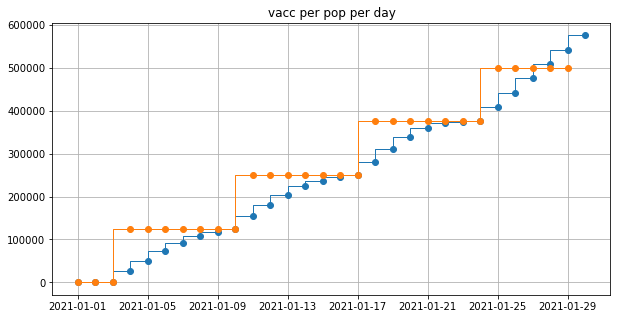

In [6]:
fig, ax = plt.subplots(1,1, figsize = (10,5))
i = 8
st = states_names[i]
st = 'vacc'
value = 'value'

ax.step(mydata[(mydata['comp'] == st)].pivot(columns = 'place', values=value).index,
        mydata[(mydata['comp'] == st)].pivot(columns = 'place', values=value).sum(axis=1).cumsum(), lw = 1, ls = '-', marker='o')
ax.step(mydata[(mydata['comp'] == st)].pivot(columns = 'place', values=value).index[:-1],  stockpile_national, lw = 1, ls = '-', marker='o')
#ax.plot(myopt[(myopt['comp'] == st)].pivot(columns = 'place', values=value), lw = 3, ls = '', marker='x')

#ax.plot(p.matlab_model_days, p.matlab_initial[:,:,i].T, linestyle='-', lw = .5)
ax.set_title(st + ' per pop per day');
ax.grid()
#ax.set_ylim(0)

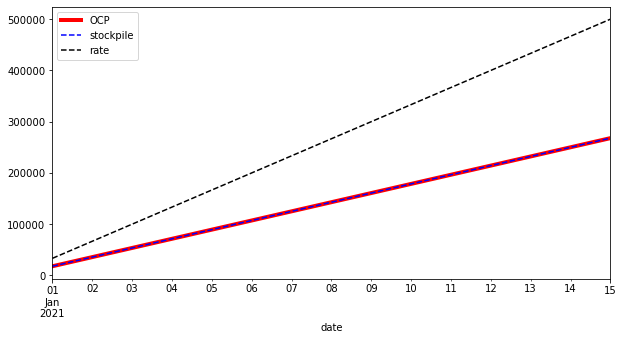

In [65]:
fig, ax = plt.subplots(1,1,figsize=(10,5))
ax = mydata[(mydata['comp'] == 'vacc')].pivot(columns = 'place', values=value).sum(axis=1).cumsum().plot(c = 'r', lw = 4, label = 'OCP')
ax.plot(mydata[(mydata['comp'] == 'vacc')].pivot(columns = 'place', values=value).sum(axis=1).index, np.cumsum(np.ones(ndays)*dosesperweek/7), c='b', ls='--', label='stockpile')
ax.plot(mydata[(mydata['comp'] == 'vacc')].pivot(columns = 'place', values=value).sum(axis=1).index, np.cumsum(np.ones(ndays)*ratepermonth/30), c='k', ls='--', label = 'rate')
ax.legend()
#ax.set_ylim(0,1e6)

In [ ]:
fig, axes = plt.subplots(5,22, figsize = (30,15), sharex=True, facecolor = 'white', sharey=True)
#fig, axes = plt.subplots(5,2, figsize = (20,10), sharex=True)#, sharey=True)
import seaborn as sns
i = 3
st = states_names[i]
print(st)
for k, nname in enumerate(setup.ind2name):
    #axes.flat[k].bar(mydata[(mydata['comp'] == st) & (mydata['placeID'] == k)]['value'].index,
    #                 mydata[(mydata['comp'] == st) & (mydata['placeID'] == k)]['value'], #linestyle='-', lw = 3,  marker='', 
    #                 color='orange')
    axes.flat[k].plot(mydata[(mydata['comp'] == st) & (mydata['placeID'] == k)]['value'], linestyle='-', lw = 2, color='r')#, marker='.')

    
    axes.flat[k].plot(p.matlab_model_days, p.matlab_initial[k,:,i], linestyle='-', lw = 1, color='k')

    axes.flat[k].set_title(nname);
    #axes.flat[k].set_ylim(0,5000)
fig.autofmt_xdate()

# All TS analysis

In [4]:
import copy
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import networkx
from ItalySetup import ItalySetup
from covidOCP import COVIDVaccinationOCP, COVIDParametersOCP
from main import pick_scenario, build_scenario
import seaborn as sns
import datetime
import pickle
import glob

nx = 9
states_names = ['S', 'E', 'P', 'I', 'A', 'Q','H', 'R', 'V']
outdir = 'model_output/'
when = 'future'
file_prefix = f'week'
myopt = None

n_int_steps = 6
nnodes = 107  # nodes
ndays = 30

setup = ItalySetup(nnodes, ndays, when)
M = setup.nnodes
N = len(setup.model_days) - 1

with open(f'italy-data/parameters_{nnodes}_{when}.pkl', 'rb') as inp:
    p = pickle.load(inp)

Loaded Italy Setup with 107 nodes.


In [5]:
outdir = '2021-01-19-107_30/'
file_list = glob.glob(outdir + '*.csv')
#outdir = '2021-01-14_nanoechopc/'
#file_list = glob.glob(outdir + 'microechopc*.csv')
file_list = [fn for fn in file_list if 'opt' in fn]
file_list.sort()
print(len(file_list))

25


In [12]:
float(filename.split('-')[-4][1:])*1e6

1000000.0

In [13]:
float(filename.split('-')[-3][1:])

12500.0

In [14]:
filename.split('-')

['2021', '01', '17', '10_30/week', 'U', 'r1', 't12500', 'opt', '10_30.csv']

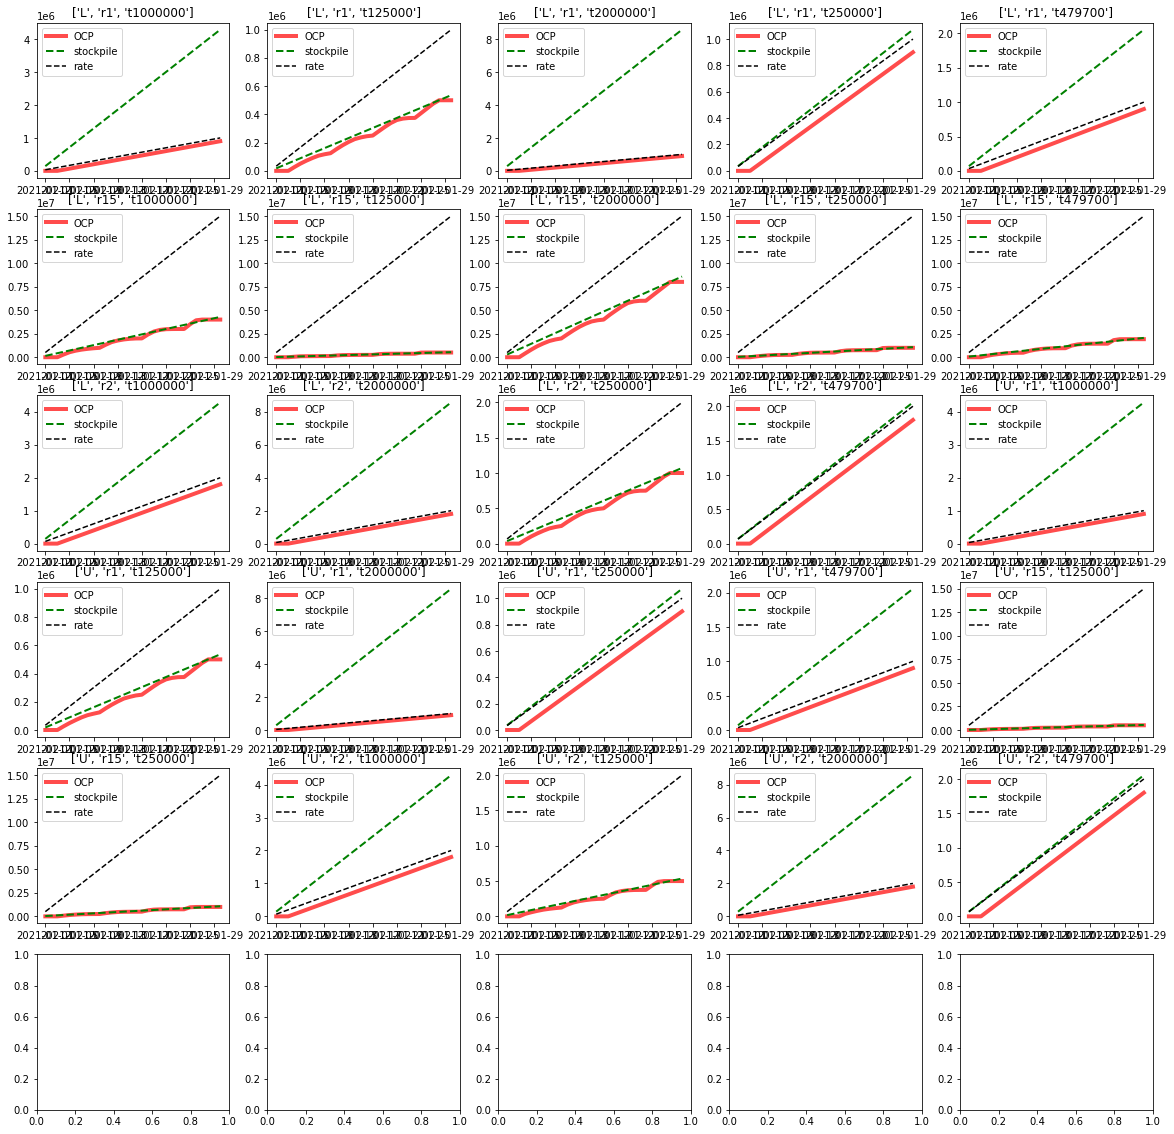

In [7]:
value = 'value'
fig, ax = plt.subplots(6,5,figsize=(20,20))#, sharex = True, sharey = True)
fig.set_facecolor('white')
ax = [ax for ax in ax.flat]

for i, filename in enumerate(file_list):
    mydata = pd.read_csv(filename, index_col= 'date', parse_dates=True)
    mydata['valuepop'] = mydata['value'] / setup.pop_node[mydata['placeID']]

    dosesperweek = float(filename.split('-')[-3][1:])
    ratepermonth = float(filename.split('-')[-4][1:])*1e6
    
    ax[i].plot(mydata[(mydata['comp'] == 'vacc')].pivot(columns = 'place', values=value).sum(axis=1).cumsum(),
               c = 'r', lw = 4, label = 'OCP', alpha = .7)
    ax[i].plot(mydata[(mydata['comp'] == 'vacc')].pivot(columns = 'place', values=value).sum(axis=1).index, 
               np.cumsum(np.ones(ndays)*dosesperweek/7), c='g', lw=2, ls='--', label='stockpile')
    ax[i].plot(mydata[(mydata['comp'] == 'vacc')].pivot(columns = 'place', values=value).sum(axis=1).index, 
               np.cumsum(np.ones(ndays)*ratepermonth/30), c='k', ls='--', label = 'rate')
    
    ax[i].legend()
    #ax[i].set_ylim(0, 1e4)
    ax[i].set_title(filename.split('-')[-5:-2])

In [17]:
for i, filename in enumerate(file_list):
    mydata = pd.read_csv(filename, index_col= 'date', parse_dates=True)
    mydata['valuepop'] = mydata['value'] / setup.pop_node[mydata['placeID']]

    dosesperweek = float(filename.split('-')[-3][1:])
    ratepermonth = float(filename.split('-')[-4][1:])*1e6/30
    print(dosesperweek, ratepermonth, filename)

12500.0 0.0 2021-01-17-10_30/week-U-r0-t12500-opt-10_30.csv
25000.0 0.0 2021-01-17-10_30/week-U-r0-t25000-opt-10_30.csv
12500.0 33333.333333333336 2021-01-17-10_30/week-U-r1-t12500-opt-10_30.csv
25000.0 33333.333333333336 2021-01-17-10_30/week-U-r1-t25000-opt-10_30.csv


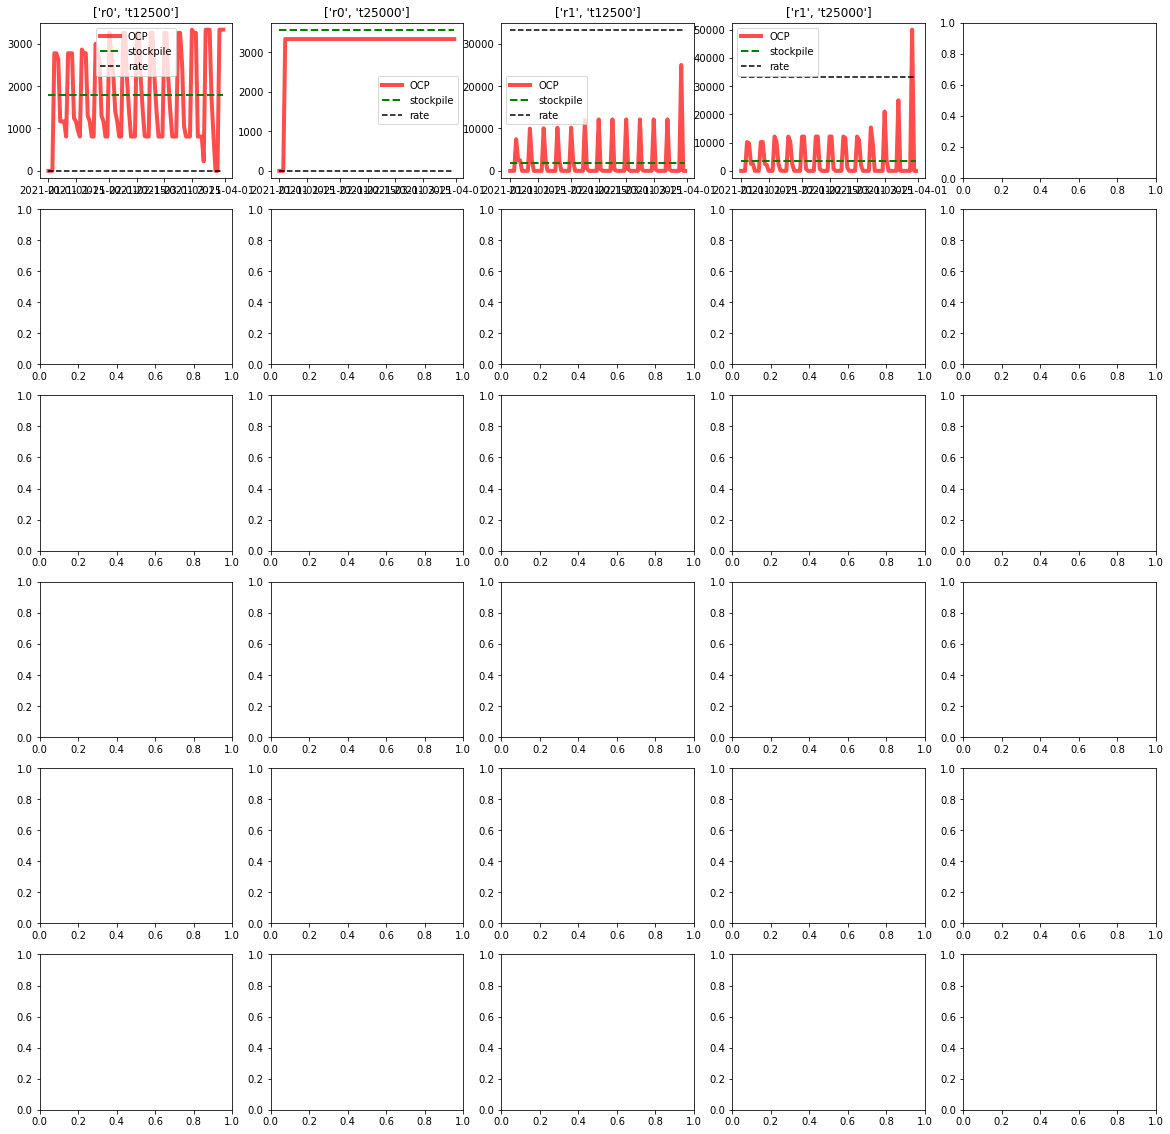

In [22]:
value = 'value'
fig, ax = plt.subplots(6,5,figsize=(20,20))#, sharex = True, sharey = True)
fig.set_facecolor('white')
ax = [ax for ax in ax.flat]

for i, filename in enumerate(file_list):
    mydata = pd.read_csv(filename, index_col= 'date', parse_dates=True)
    mydata['valuepop'] = mydata['value'] / setup.pop_node[mydata['placeID']]

    dosesperweek = float(filename.split('-')[-3][1:])
    ratepermonth = float(filename.split('-')[-4][1:])*1e6
    
    ax[i].plot(mydata[(mydata['comp'] == 'vacc')].pivot(columns = 'place', values=value).sum(axis=1),
               c = 'r', lw = 4, label = 'OCP', alpha = .7)
    ax[i].plot(mydata[(mydata['comp'] == 'vacc')].pivot(columns = 'place', values=value).sum(axis=1).index, 
               np.ones(ndays)*dosesperweek/7, c='g', lw=2, ls='--', label='stockpile')
    ax[i].plot(mydata[(mydata['comp'] == 'vacc')].pivot(columns = 'place', values=value).sum(axis=1).index, 
               np.ones(ndays)*ratepermonth/30, c='k', ls='--', label = 'rate')
    
    ax[i].legend()
    #ax[i].set_ylim(0, 1e6)
    ax[i].set_title(filename.split('-')[-4:-2])